In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
from STEM.model import *
from STEM.utils import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
scdata = pd.read_csv('./data/mousedata_2020/E3z2/counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('./data/mousedata_2020/E3z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/mousedata_2020/E3z2/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('./data/mousedata_2020/E3z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('./data/mousedata_2020/E3z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata,obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor

In [3]:
sc.pp.calculate_qc_metrics(adata,percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(stadata,percent_top=None, log1p=False, inplace=True)

In [4]:
dp = 1- adata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()

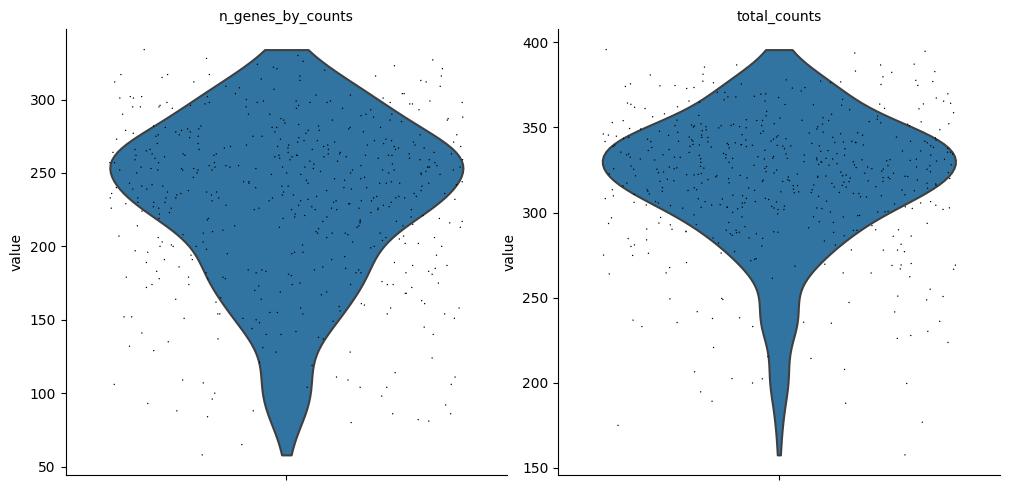

In [5]:
figsize(2,2)
sc.pl.violin(stadata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'embryo' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future ver

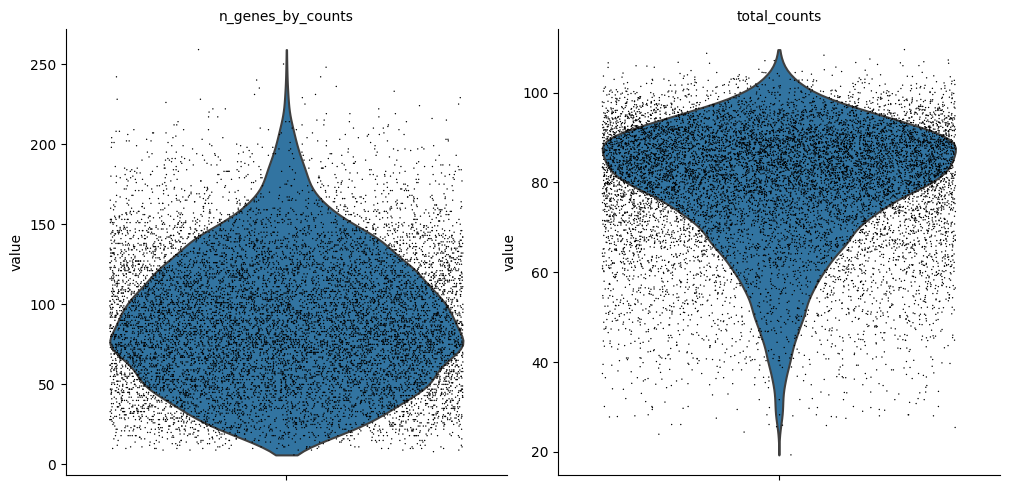

In [6]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

In [7]:
class setting( object ):
    pass
seed_all(2022)
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', 'log/Mouse_E3z2')
setattr(opt, 'n_genes', 351)
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 7)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)
setattr(opt, 'mmdbatch', 1000)
setattr(opt, 'dp', dp)

In [8]:
%%time
testmodel =  SOmodel(opt)
testmodel.togpu()
loss_curve = testmodel.train_wholedata(400,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())

[Train][0] Loss: E 2.935 E_pred 2.875 E_circle 5.201 E_mmd 0.075
[0.002]
[Train][1] Loss: E 4.268 E_pred 4.233 E_circle 5.645 E_mmd 0.043
[0.002]
[Train][2] Loss: E 3.267 E_pred 3.231 E_circle 5.280 E_mmd 0.046
[0.002]
[Train][3] Loss: E 2.839 E_pred 2.807 E_circle 4.999 E_mmd 0.041
[0.002]
[Train][4] Loss: E 2.696 E_pred 2.669 E_circle 4.846 E_mmd 0.034
[0.002]
[Train][5] Loss: E 2.844 E_pred 2.813 E_circle 4.754 E_mmd 0.039
[0.002]
[Train][6] Loss: E 2.668 E_pred 2.639 E_circle 4.718 E_mmd 0.035
[0.002]
[Train][7] Loss: E 2.632 E_pred 2.602 E_circle 4.313 E_mmd 0.037
[0.002]
[Train][8] Loss: E 2.566 E_pred 2.539 E_circle 4.466 E_mmd 0.034
[0.002]
[Train][9] Loss: E 2.527 E_pred 2.501 E_circle 4.293 E_mmd 0.032
[0.002]
[Train][10] Loss: E 2.547 E_pred 2.523 E_circle 4.413 E_mmd 0.030
[0.002]
[Train][11] Loss: E 2.492 E_pred 2.469 E_circle 4.201 E_mmd 0.029
[0.002]
[Train][12] Loss: E 2.500 E_pred 2.478 E_circle 4.091 E_mmd 0.027
[0.002]
[Train][13] Loss: E 2.490 E_pred 2.465 E_circle 

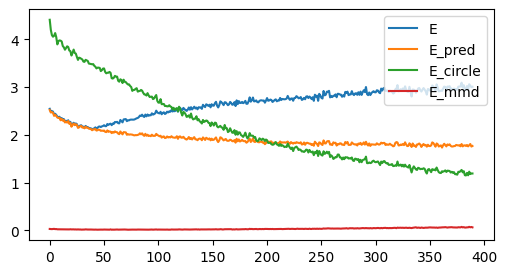

In [9]:
figsize(6,3)
skip=10
N = len(loss_curve['E'])-skip
plt.plot(np.arange(N),loss_curve['E'][skip:],label='E')
plt.plot(np.arange(N),loss_curve['E_pred'][skip:],label='E_pred')
plt.plot(np.arange(N),loss_curve['E_circle'][skip:],label='E_circle')
plt.plot(np.arange(N),loss_curve['E_mmd'][skip:],label='E_mmd')
plt.legend()

In [10]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()

In [11]:
np.save('result/230215_testdp_pure_mmd-E3z2.npy',netst2sc)
np.save('result/230215_testdp_pure_sc2st_mmd-E3z2.npy',netsc2st)
np.save('result/230215_scembbedding-E3z2.npy',scembedding.detach().cpu().numpy())
np.save('result/230215_stembbedding-E3z2.npy',stembedding.detach().cpu().numpy())

In [14]:
testmodel.save()

In [15]:
celltypelist=stgtcelltype.columns[((stgtcelltype>0.1).sum(0)>10)].tolist()
print(celltypelist)

['Allantois', 'Anterior somitic tissues', 'Blood progenitors', 'Cardiomyocytes', 'Cranial mesoderm', 'Dermomyotome', 'Endothelium', 'Erythroid', 'Forebrain/Midbrain/Hindbrain', 'Gut tube', 'Haematoendothelial progenitors', 'Intermediate mesoderm', 'Lateral plate mesoderm', 'Mixed mesenchymal mesoderm', 'Neural crest', 'Presomitic mesoderm', 'Sclerotome', 'Spinal cord', 'Splanchnic mesoderm', 'Surface ectoderm']


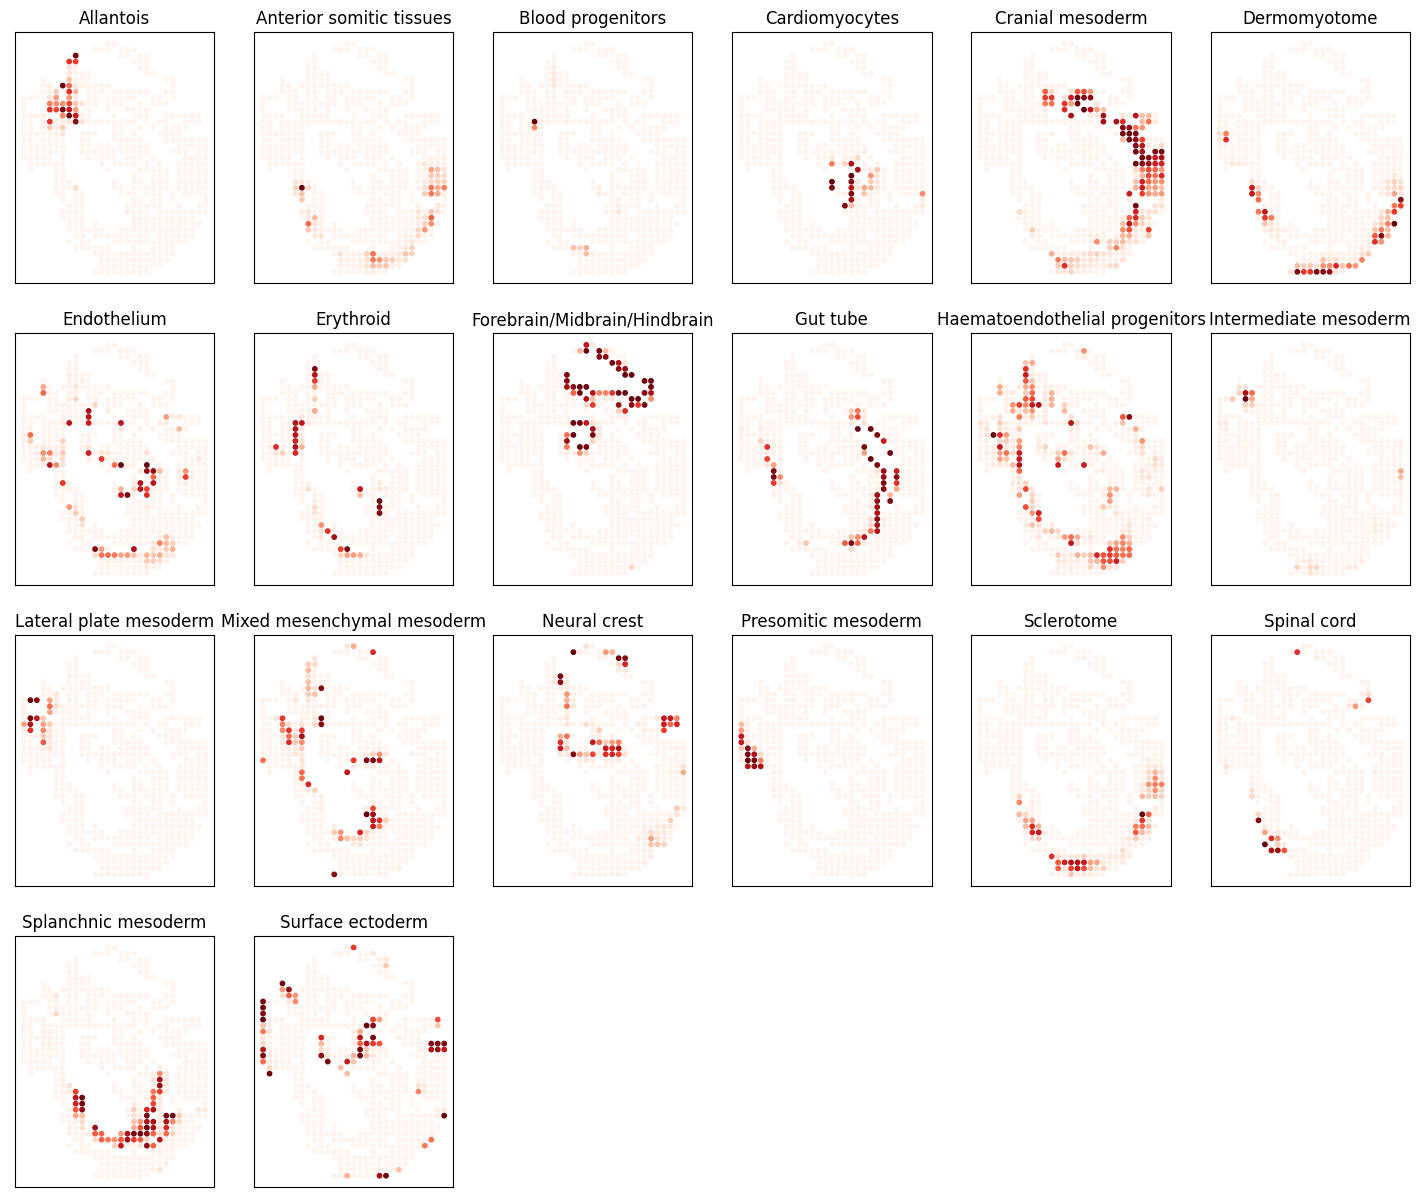

In [16]:
figsize(18,15)
for i in range(len(celltypelist)):
    subplot(4,6,i+1)
    name = celltypelist[i]
    spinalcord = netst2sc[:,scmetadata.celltype_mapped_refined==name].mean(1)    
    plt.scatter(spcoor.coord_x,-spcoor.coord_y,c = spinalcord,cmap='Reds',s=10)
    plt.title(name)
    plt.xticks([])
    plt.yticks([])

In [17]:
import scipy
pr_spaotsc=[]
for i in range(stgtcelltype.shape[1]):
    name = stgtcelltype.columns[i]
    scl =  netst2sc[:,scmetadata.celltype_mapped_refined==name].mean(1)    
    pearson = scipy.stats.pearsonr(stgtcelltype.iloc[:,i],scl)[0]
    pr_spaotsc.append(pearson)
    if np.isnan(pearson):
        pearson=0
    print(pearson,'\t',stgtcelltype.columns[i])
pr_spaotsc = pd.DataFrame(pr_spaotsc,index=stgtcelltype.columns).T

0.8808100258148785 	 Allantois
0.577450580240425 	 Anterior somitic tissues
0.2552591300598884 	 Blood progenitors
0.907695871983516 	 Cardiomyocytes
0.8456377016958454 	 Cranial mesoderm
0.6268909101295722 	 Definitive endoderm
0.84366650142375 	 Dermomyotome
0.7456169196587271 	 Endothelium
0.8555543721970011 	 Erythroid
0.12471966409345 	 ExE endoderm
0.9410474667819978 	 Forebrain/Midbrain/Hindbrain
0.9501991127831089 	 Gut tube
0.5027005178860795 	 Haematoendothelial progenitors
0.6783368322249427 	 Intermediate mesoderm
0.8906458346039259 	 Lateral plate mesoderm
0.8088987022263823 	 Mixed mesenchymal mesoderm
0.8920278215264333 	 NMP
0.7879834711650834 	 Neural crest
0.9640711226459379 	 Presomitic mesoderm
0.7327631066582233 	 Sclerotome
0.8418611476855866 	 Spinal cord
0.8995823044770795 	 Splanchnic mesoderm
0.8789457326845977 	 Surface ectoderm
